# Optimizing Our Hyperparameters

Since the Random Forest and Gradient Boosting performed nearly the same, we are going to try to optimize Gradient Boosting as it is much faster than Random Forest. 

We will attempt to optimize for both ROC AUC and F1 scoring and see which one improves our model the best. 

In [21]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('datasets/MLready.csv', index_col='id')
df.head()

C:\Users\hunte\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,x0_B,x0_C,x0_D,x0_E,x0_F,x0_G,x1_MORTGAGE,x1_NONE,x1_OWN,x1_RENT,x2_Source Verified,x2_Verified,x3_MORTGAGE,x3_NONE,x3_OWN,x3_RENT,x4_credit_card,x4_debt_consolidation,x4_educational,x4_home_improvement,x4_house,x4_major_purchase,x4_medical,x4_moving,x4_other,x4_renewable_energy,x4_small_business,x4_vacation,x4_wedding
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,36,13.99,123.03,10,55000.0,5.91,0.0,675.0,679.0,1.0,30.0,-999.0,7.0,0.0,2765.0,29.7,13.0,564.0,560.0,0.0,30.0,0.0,722.0,144904.0,21.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68355089,24700.0,36,11.99,820.28,10,65000.0,16.06,1.0,715.0,719.0,4.0,6.0,-999.0,22.0,0.0,21470.0,19.2,38.0,699.0,695.0,0.0,-999.0,0.0,0.0,204396.0,19.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,113.0,192.0,2.0,2.0,4.0,2.0,-999.0,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66310712,35000.0,60,14.85,829.90,10,110000.0,17.06,0.0,785.0,789.0,0.0,-999.0,-999.0,13.0,0.0,7802.0,11.6,17.0,679.0,675.0,0.0,-999.0,0.0,0.0,301500.0,23.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,36.0,87.0,2.0,2.0,1.0,2.0,-999.0,-999.0,-999.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68476807,10400.0,60,22.45,289.91,3,104433.0,25.37,1.0,695.0,699.0,3.0,12.0,-999.0,12.0,0.0,21929.0,64.5,35.0,704.0,700.0,0.0,-999.0,0.0,0.0,331730.0,14.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68426831,11950.0,36,13.44,405.18,4,34000.0,10.20,0.0,690.0,694.0,0.0,-999.0,-999.0,5.0,0.0,8822.0,68.4,6.0,759.0,755.0,0.0,-999.0,0.0,0.0,12798.0,338.0,12900.0,0.0,2560.0,844.0,91.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,-999.0,-999.0,-999.0,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
X = df.drop(columns='default')
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=7)

# ROC AUC Optimization

First, we establish a baseline for ROC AUC scores. 

In [4]:
baseclf = lgb.LGBMClassifier()

In [13]:
baseroc_cv_scores = cross_val_score(baseclf, X_train, y_train, cv=5, scoring='roc_auc')
print(f'Baseline CV ROC AUC scores: {baseroc_cv_scores}')
print(f'Baseline mean ROC AUC scores: {baseroc_cv_scores.mean()}')

Baseline CV ROC AUC scores: [0.95914846 0.95863194 0.95866639 0.95894446 0.95853578]
Baseline mean ROC AUC scores: 0.9587854087348091


Then we list all the parameters we want our function to test through along with what values to use for testing. 

In [6]:
space = [Real(0.01, 0.5, name='learning_rate', prior='log-uniform'),
         Integer(-1, 30, name='max_depth'),
         Integer(2, 100, name='num_leaves'),
         Integer(10, 1000, name='min_data_in_leaf'),
         Real(0.1, 1.0, name='feature_fraction', prior='uniform'),
         Real(0.1, 1.0, name='subsample', prior='uniform')]

In [7]:
clf = lgb.LGBMClassifier()

In [8]:
@use_named_args(space)
def rocaucobjective(**params):
    clf.set_params(**params)
    return -np.mean(cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1, scoring="roc_auc"))


We will be using gp_minimize along with our function to optimize our classifier. 

In [9]:
roc_gp = gp_minimize(rocaucobjective, space, n_calls=200)

In [10]:
print("""Best parameters:
- learning_rate=%.6f
- max_depth=%d
- num_leaves=%d
- min_data_in_leaf=%d
- feature_fraction=%.6f
- subsample=%.6f""" % (roc_gp.x[0], roc_gp.x[1], 
                            roc_gp.x[2], roc_gp.x[3], 
                            roc_gp.x[4],roc_gp.x[5]))

Best parameters:
- learning_rate=0.098287
- max_depth=30
- num_leaves=100
- min_data_in_leaf=1000
- feature_fraction=0.572435
- subsample=1.000000


Now that we have our hyperparameters, let's put them to the test. 

In [6]:
rocclf = lgb.LGBMClassifier(learning_rate=0.098287, max_depth=30, num_leaves=100, min_data_in_leaf=1000, 
                            feature_fraction=.572435, subsample=.1)

In [14]:
roc_cv_scores = cross_val_score(rocclf, X_train, y_train, cv=5, scoring='roc_auc')
print(f'ROC CV scores: {roc_cv_scores}')
print(f'ROC CV mean scores: {roc_cv_scores.mean()}')
print(f'Our mean ROC AUC score improved by {roc_cv_scores.mean() - baseroc_cv_scores.mean()}')

ROC CV scores: [0.95976351 0.95918205 0.95932349 0.95952403 0.95909166]
ROC CV mean scores: 0.9593769466004319
Our mean ROC AUC score improved by 0.0005915378656228265


After all that, our classifier improved negligibly. Let's see how f1 optimization fares.  

# F1 Scoring Optimization 

Now we will exactly the same as before but apply it to f1 optimization. 

In [8]:
baseclf = lgb.LGBMClassifier()

In [9]:
base_f1cv_scores = cross_val_score(baseclf, X_train, y_train, cv=5, scoring='f1')
print(f'Baseline CV F1 scores: {base_f1cv_scores}')
print(f'Baseline mean F1 scores: {base_f1cv_scores.mean()}')

Baseline CV F1 scores: [0.74832162 0.74648361 0.74808544 0.75010108 0.74713777]
Baseline mean F1 scores: 0.7480259035225434


In [15]:
f1clf = lgb.LGBMClassifier()

In [16]:
@use_named_args(space)
def f1objective(**params):
    clf.set_params(**params)
    return -np.mean(cross_val_score(f1clf, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="f1"))

In [17]:
f1_gp = gp_minimize(f1objective, space, n_calls=200)

C:\Users\hunte\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\hunte\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\hunte\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\hunte\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\hunte\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\hunte\

In [18]:
print("""Best parameters:
- learning_rate=%.6f 
- max_depth=%d
- num_leaves=%d
- min_data_in_leaf=%d
- feature_fraction=%.6f
- subsample=%.6f""" % (f1_gp.x[0], f1_gp.x[1], f1_gp.x[2], f1_gp.x[3], f1_gp.x[4],f1_gp.x[5]))


Best parameters:
- learning_rate=0.011324 
- max_depth=2
- num_leaves=29
- min_data_in_leaf=131
- feature_fraction=0.846410
- subsample=0.619899


In [10]:
f1clf = lgb.LGBMClassifier(learning_rate=0.011324, max_depth=2, num_leaves=29, min_data_in_leaf=131, 
                            feature_fraction=0.846410, subsample=0.619899)


In [15]:
f1clf_cv_scores = cross_val_score(f1clf, X_train, y_train, cv=5, scoring='f1')
print(f'F1 Classifier CV F1 scores: {f1clf_cv_scores}')
print(f'F1 Classifier mean F1 scores: {f1clf_cv_scores.mean()}')
print(f'Our mean F1 score improved by {f1clf_cv_scores.mean() - base_f1cv_scores.mean()}')

F1 Classifier CV F1 scores: [0.64145833 0.6445747  0.64371958 0.64282599 0.64119685]
F1 Classifier mean F1 scores: 0.6427550894594916
Our mean F1 score improved by -0.10527081406305183


And our f1 scores actually came out quite a bit worse. This does not bode well for improving our model but since we're here, let's give it a shot anyway. 

# Putting Classifiers To The Test

Establish our baseline:

In [18]:
baseclf = lgb.LGBMClassifier()
baseclf.fit(X_train, y_train)

print ("\n\n ---Default Model---")
base_roc_auc = roc_auc_score(y_test, baseclf.predict(X_test))
print ("ROC AUC = %2.2f" % base_roc_auc)
print(classification_report(y_test, baseclf.predict(X_test), digits=4))



 ---Default Model---
ROC AUC = 0.85
              precision    recall  f1-score   support

           0     0.9583    0.9566    0.9575    211463
           1     0.7423    0.7502    0.7463     35214

    accuracy                         0.9272    246677
   macro avg     0.8503    0.8534    0.8519    246677
weighted avg     0.9275    0.9272    0.9273    246677



Compare the ROC AUC optimized model:

In [17]:
rocclf = lgb.LGBMClassifier(learning_rate=0.098287, max_depth=30, num_leaves=100, min_data_in_leaf=1000, 
                            feature_fraction=.572435, subsample=.1)
rocclf.fit(X_train, y_train)

print ("\n\n ---ROC AUC Model---")
roc_roc_auc = roc_auc_score(y_test, rocclf.predict(X_test))
print ("ROC AUC = %2.2f" % roc_roc_auc)
print(classification_report(y_test, rocclf.predict(X_test), digits=4))



 ---ROC AUC Model---
ROC AUC = 0.85
              precision    recall  f1-score   support

           0     0.9583    0.9567    0.9575    211463
           1     0.7427    0.7502    0.7465     35214

    accuracy                         0.9272    246677
   macro avg     0.8505    0.8535    0.8520    246677
weighted avg     0.9276    0.9272    0.9274    246677



This is better by only the slimmest of margins. 

Finally, let's compare the F1 optimized model:

In [19]:
f1clf = lgb.LGBMClassifier(learning_rate=0.011324, max_depth=2, num_leaves=29, min_data_in_leaf=131, 
                            feature_fraction=0.846410, subsample=0.619899)
f1clf.fit(X_train, y_train)

print ("\n\n ---F1 Model---")
f1_roc_auc = roc_auc_score(y_test, f1clf.predict(X_test))
print ("ROC AUC = %2.2f" % f1_roc_auc)
print(classification_report(y_test, f1clf.predict(X_test), digits=4))



 ---F1 Model---
ROC AUC = 0.76
              precision    recall  f1-score   support

           0     0.9274    0.9738    0.9501    211463
           1     0.7753    0.5422    0.6381     35214

    accuracy                         0.9122    246677
   macro avg     0.8514    0.7580    0.7941    246677
weighted avg     0.9057    0.9122    0.9055    246677



And this one is worse than our baseline. Looks like ROC AUC optimization was the way to go. 

# Final Analysis

#### Feature Importances

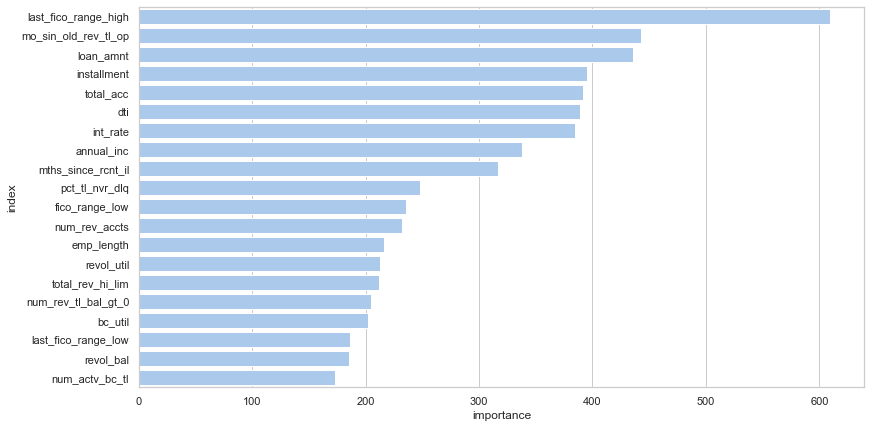

In [26]:
feature_importances = pd.DataFrame(rocclf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances.head(20),
            label="Total", color="b")
plt.show()

I'll go over the most important features here. I'll start with the definition of the feature and and explain how our model interprets its importance to predicting default. 

last_fico_range_high - Most recent credit pull is the best predictor as we would expect. Recent delinquent credit such as missed or late payments on any account, defaulted loans, or newly opened credit obligations will all bring this number down.

mo_sin_old_rev_tl_op - Months since oldest revolving account opened. Revolving accounts are lines of credit such as credit cards. A low number here indicates a lack of credit history indicating that the borrower doesn't have a history of paying debts off so we would expect them to be more likely to default.

loan_amnt & installment - The installment (monthly payment) will vary based on the loan amount and interest rate. The higher the loan amount, and thus the monthly payment, the more likely the default. 

total_acc & dti - The total number of credit lines currently in the borrower's credit file and debt to income. The more accounts, the more debt obligations, the more likely a customer is to default. DTI is the actual ratio of the monthly debts of these accounts over the borrower's income. It's essentially a measure of the borrower's capacity for more debt. 

int_rate - Interest rate is a chicken or egg dilemma. Higher interest rates are assigned to riskier borrowers to get investors to take them on but the interest rate itself makes the loan more difficult to pay off. The lower the interest rate the more likely the borrower is not default. 

annual_inc - Annual income. Obviously if a borrower has low annual income, we would expect them to be more likely to default. 

mths_since_recent_il - Months since most recent installment accounts opened. Installment accounts are loans. If a borrower hasn't taken on any other installment loans recently, they should be more prepared to pay off their loan. 


